In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

from PyCo.ContactMechanics import HardWall
from PyCo.SolidMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from PyCo.Topography import Topography
from PyCo.System import make_system

# Generate Cone

Text(0, 0.5, 'heights (mm)')

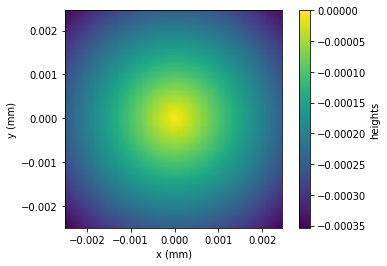

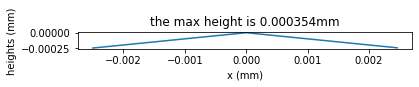

In [2]:
nx, ny = 128,128

sx = 0.005 # mm
sy = 0.005 # mm

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2
X = x * np.ones_like(y)
Y = y * np.ones_like(x)

topography= Topography(- np.sqrt(x**2 + y**2 ) *0.1, physical_sizes=(sx, sy) )
Max_Height=(-1)*np.min(topography.heights())

angle=np.arctan(10)
beta=np.pi/2-angle

fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh(X, Y , topography.heights()), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//2])
ax.set_title("the max height is {0:.6f}mm".format(Max_Height))
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("heights (mm)")

# Establish Foundamental Parametere

In [3]:
# Defining Young's Module/ MPa
Es = 500
# Establishing PeriodicFFTElasticHalfSpace
substrate = FreeFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes=(sx, sy))
interaction=HardWall()
# Establishing Interaction
system = make_system(substrate, interaction, topography)

In [4]:
def Load_and_MPressure(Contact_R,beta):
    v=1/4
    E=Es/(1-v**2)
    exter_load=np.pi*Contact_R**2*E*np.tan(beta)/2
    mean_Pressure=exter_load/(np.pi*Contact_R**2)
    return exter_load,mean_Pressure

def contact_R_and_Area(penetration):
    beta=np.pi/2-angle
    a=2*penetration/(np.pi*np.tan(beta))
    area=np.pi*a**2
    return a,area

def deformation(penetration,contact_radius):
    Deformation=np.zeros_like(X)
    r=penetration*np.tan(angle)
    R=np.sqrt(x**2 + y**2 )
    if contact_radius==0:
        Deformation[:,:]=0
    else:
        R_scale_0=(R<=contact_radius)
        Deformation[R_scale_0]=(np.max(R[R_scale_0])-R[R_scale_0])*np.tan(beta)+penetration*(1-2/np.pi)
        
        R_scale_1=(R==contact_radius)
        Deformation[R_scale_1]=penetration*(1-2/np.pi)

        R_scale_2=(R>=contact_radius)
        Deformation[R_scale_2]=2*penetration*(np.arcsin(contact_radius/R[R_scale_2])-R[R_scale_2]/contact_radius+np.sqrt((R[R_scale_2]/contact_radius)**2-1))/np.pi
    
    return Deformation

def pressure(penetration,mean_pressure,contact_radius):
    pressure=np.zeros_like(X)
    R=np.sqrt(x**2 + y**2 )
    r=penetration*np.tan(angle)
    R_scale=(R<=contact_radius)
    pressure[R_scale]=mean_pressure*np.arccosh(contact_radius/R[R_scale])
    return pressure

# Based on PyCo Code and Formulars

/opt/apps/lmod/PyCo/temp-mufft-fftw/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/opt/apps/lmod/PyCo/temp-mufft-fftw/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/apps/lmod/PyCo/temp-mufft-fftw/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


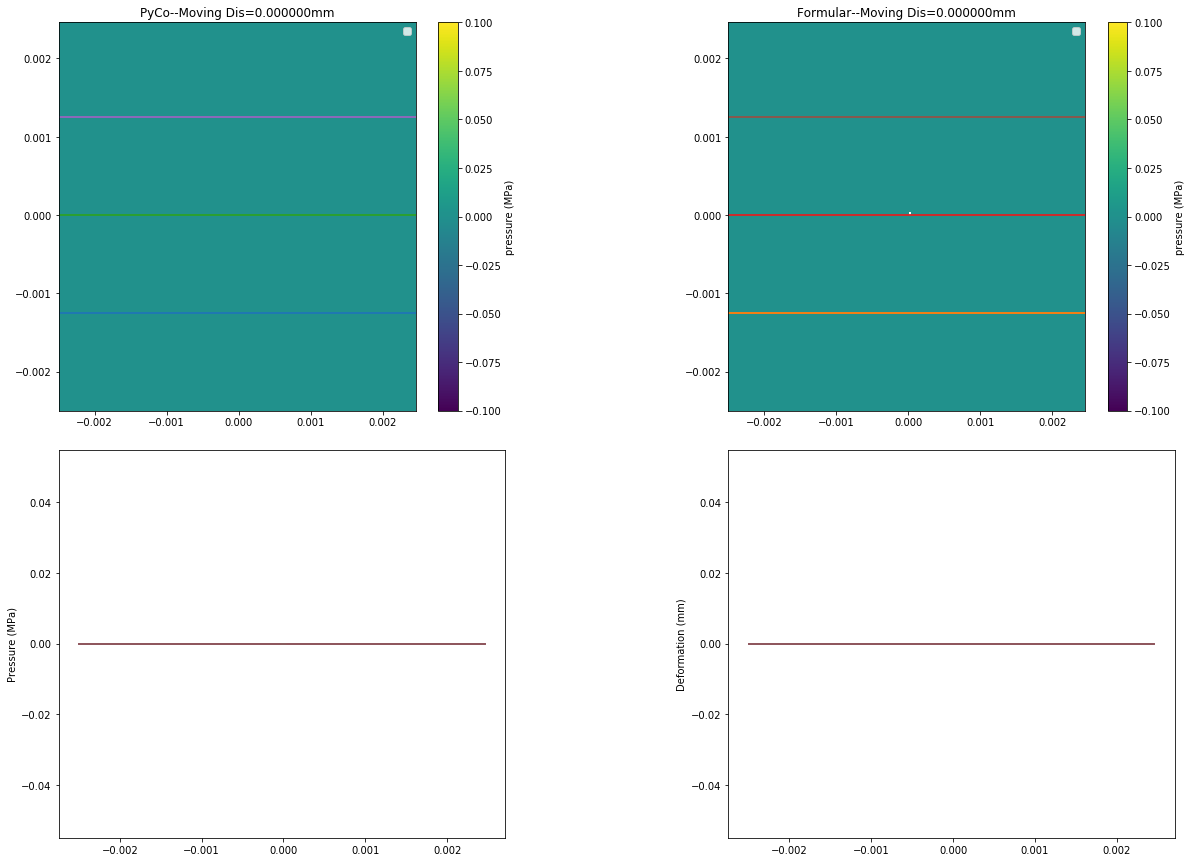

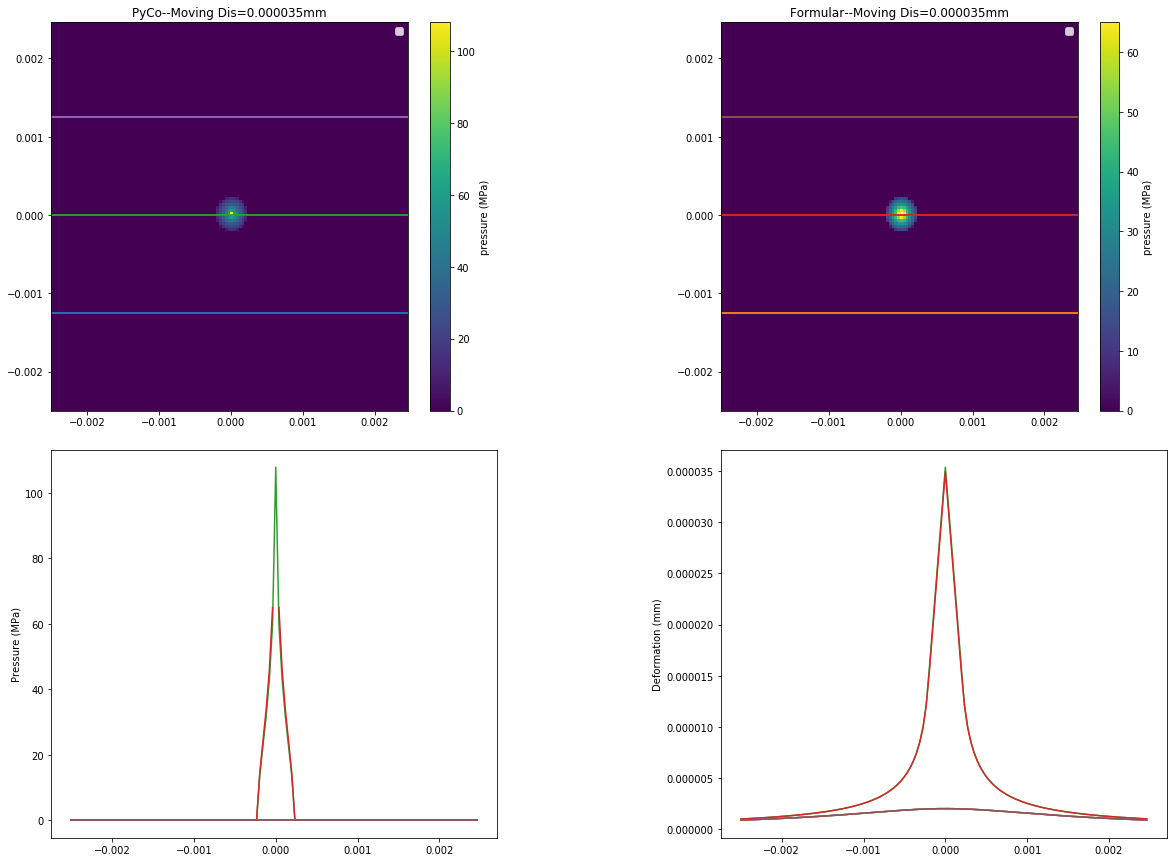

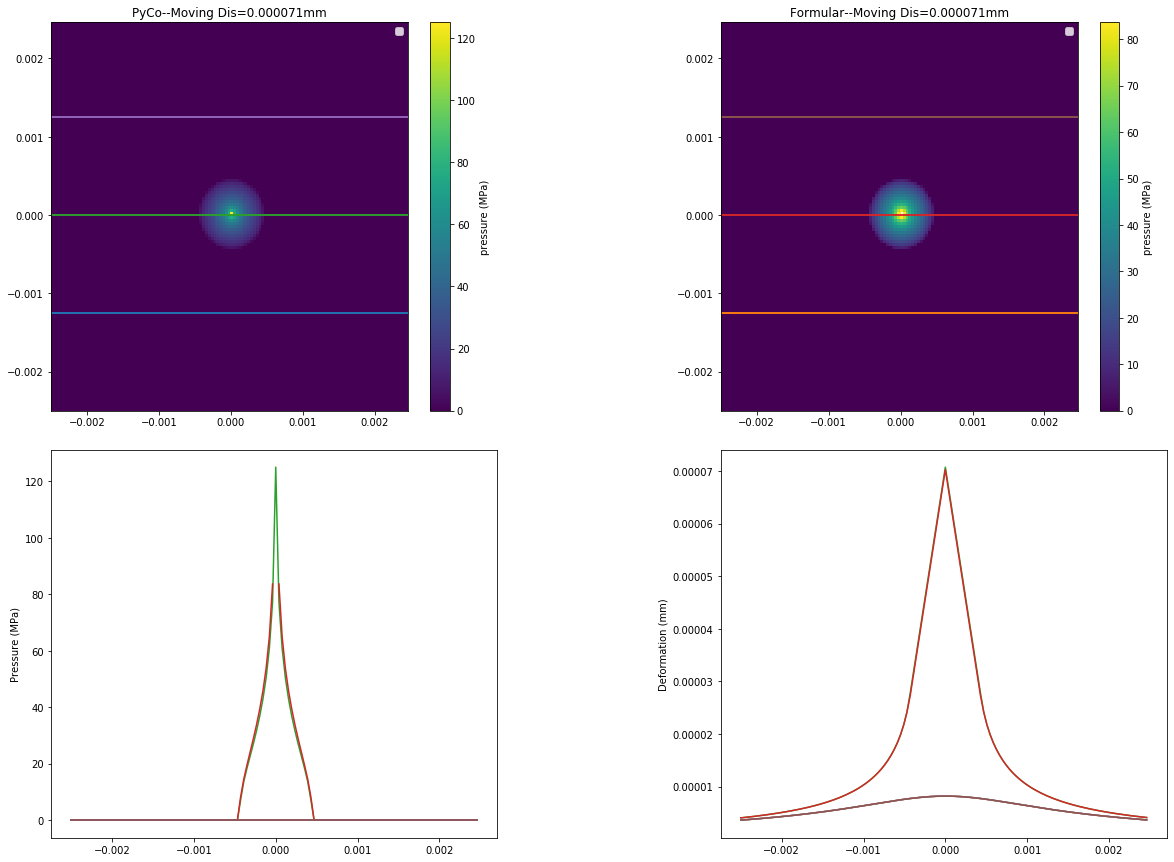

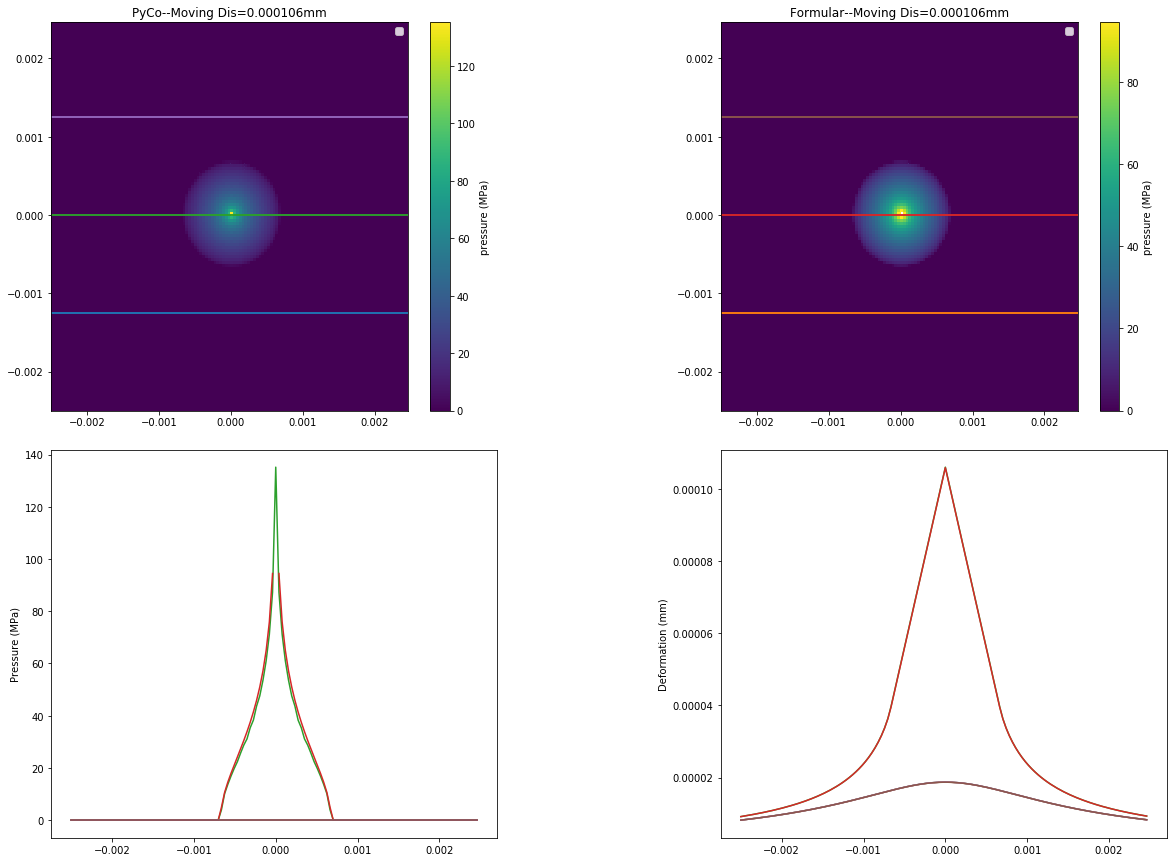

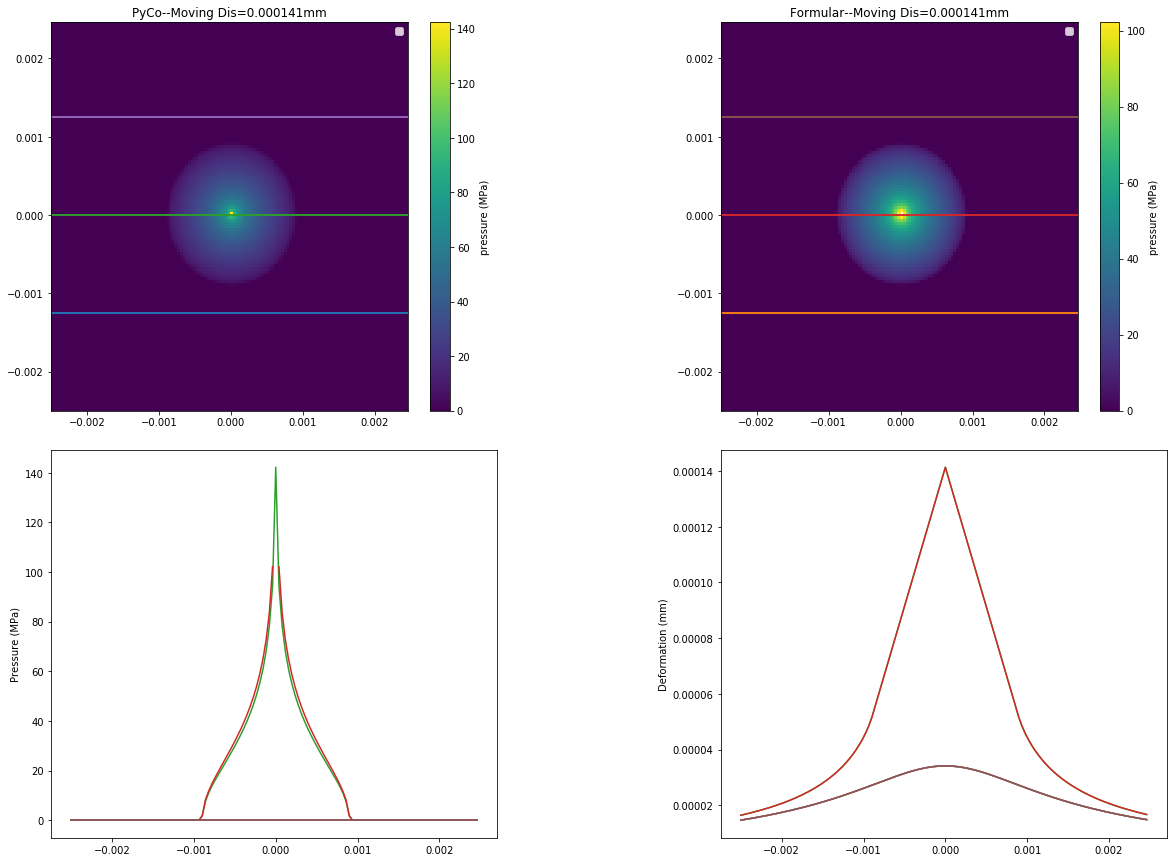

In [7]:
penetration =[]
Exter_load , F_External_load =[] , []
Max_Pressure , F_Max_Pressure =[] , []
Contact_Area , F_Contact_Area =[] , []

for Times in range(5):
    unit_depth=Max_Height/10
    penetration.append(unit_depth*Times)
#based on PyCo 
    sol=system.minimize_proxy(offset=penetration[Times])
    assert sol.success
    Contact_Area.append(system.compute_contact_area())# compute contact area by PyCo

    Exter_load.append(system.compute_normal_force())# compute external load by PyCo

    DEformation=(-1)*substrate.evaluate_disp(system.force) # make deformation positive by PyCo

    Max_Pressure.append(np.max(system.force / system.area_per_pt))# compute Max pressure by PyCo

# based on Formulars
    contact_radius,Area=contact_R_and_Area(penetration[Times])# compute contact radius and contact area by formulars
    F_Contact_Area.append(Area)

    External_load,Mean_pressure=Load_and_MPressure(contact_radius,beta)# compute external load and mean pressure by formulars
    F_External_load.append(External_load)

    Deformation=deformation(penetration[Times],contact_radius)# make deformation positive by Formulars

    max_pressure=pressure(penetration[Times],Mean_pressure,contact_radius)# compute Max pressure by PyCo
    F_Max_Pressure.append(np.max(max_pressure))    
    
    plt.figure(figsize=(20,15))
    plt.subplots_adjust(wspace=0.5,hspace=0.1)
    ax3D1,ax3D2,ax3D3,ax3D4=plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)
    
    pcm=ax3D1.pcolormesh(X,Y, system.force / system.area_per_pt)
    plt.colorbar(pcm, ax = ax3D1, label= "pressure (MPa)")
    ax3D1.set_title("PyCo--Moving Dis={0:.6f}mm".format(penetration[Times]))
    ax3D1.legend()
    
    pcm=ax3D2.pcolormesh(X,Y, max_pressure) 
    plt.colorbar(pcm, ax = ax3D2, label= "pressure (MPa)")
    ax3D2.set_title("Formular--Moving Dis={0:.6f}mm".format(penetration[Times])) 
    ax3D2.legend()
    
    for Cro_Section in [ny//4,ny//2,ny*3//4]:
        P,=ax3D3.plot(X[:,Cro_Section],system.force[:,Cro_Section] / system.area_per_pt,label='PyCo')
        F_P,=ax3D3.plot(X[:,Cro_Section],max_pressure[:,Cro_Section],label='Formular')
        ax3D3.set_ylabel('Pressure (MPa)')
        ax3D1.axhline(Y[0,Cro_Section],color=P.get_color())
        ax3D2.axhline(Y[0,Cro_Section],color=F_P.get_color())
        
        
        D,=ax3D4.plot(X[:,Cro_Section],DEformation[:,Cro_Section],label='PyCo')
        F_D,=ax3D4.plot(X[:,Cro_Section],Deformation[:,Cro_Section],label='Formular')
        ax3D4.set_ylabel('Deformation (mm)')
        ax3D1.axhline(Y[0,Cro_Section],color=D.get_color())
        ax3D2.axhline(Y[0,Cro_Section],color=F_D.get_color())
        

# Plot of Offset & External_load

Text(0.5, 1.0, 'Difference External load between PyCo and Formulars')

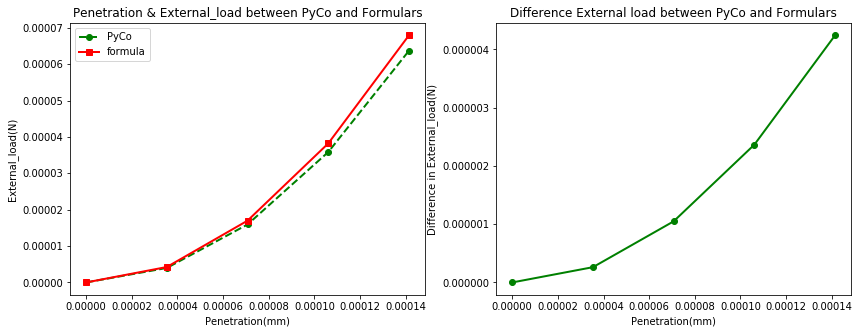

In [8]:
fig,(ax1,ad1)=plt.subplots(1,2,figsize=(14,5))

Difference_External_load=abs(np.array(Exter_load)-np.array(F_External_load))
ax1.plot(penetration,Exter_load,color="green",marker="o",linestyle="dashed",linewidth=2,label="PyCo")
ax1.plot(penetration,F_External_load,color="red",marker="s",linewidth=2,label="formula")
ax1.set_xlabel("Penetration(mm)")
ax1.set_ylabel("External_load(N)")
ax1.set_title("Penetration & External_load between PyCo and Formulars")
ax1.legend()

ad1.plot(penetration,Difference_External_load,color="green",marker="o",linewidth=2)
ad1.set_xlabel("Penetration(mm)")
ad1.set_ylabel("Difference in External_load(N)")
ad1.set_title("Difference External load between PyCo and Formulars")

# Plot of Offset & Max_Pressure

Text(0.5, 1.0, 'Difference Max Pressure between PyCo and Formulars')

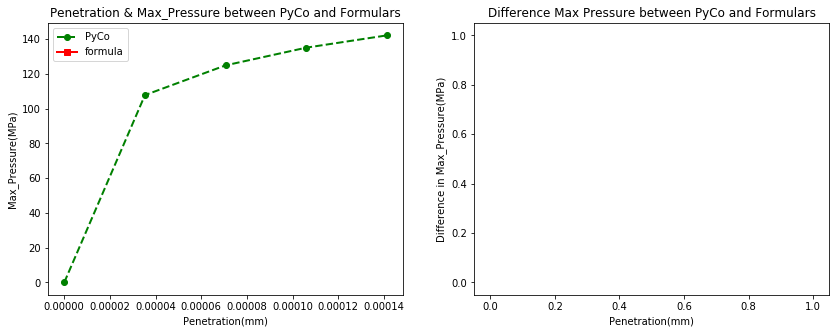

In [9]:
fig,(ax2,ad2)=plt.subplots(1,2,figsize=(14,5))
Difference_Max_Pressure=abs(np.array(Max_Pressure)-np.array(F_Max_Pressure))
ax2.plot(penetration,Max_Pressure,color="green",marker="o",linestyle="dashed",linewidth=2,label="PyCo")
ax2.plot(penetration,F_Max_Pressure,color="red",marker="s",linewidth=2,label="formula")
ax2.set_xlabel("Penetration(mm)")
ax2.set_ylabel("Max_Pressure(MPa)")
ax2.set_title("Penetration & Max_Pressure between PyCo and Formulars")
ax2.legend()

ad2.plot(penetration,Difference_Max_Pressure,color="green",marker="o",linewidth=2)
ad2.set_xlabel("Penetration(mm)")
ad2.set_ylabel("Difference in Max_Pressure(MPa)")
ad2.set_title("Difference Max Pressure between PyCo and Formulars")

# Plot of Offset & Contact_Area

Text(0.5, 1.0, 'Difference Contact Area between PyCo and Formulars')

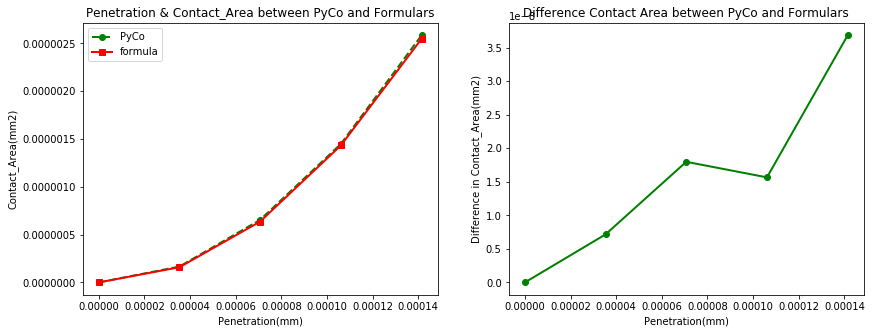

In [10]:
fig,(ax3,ad3)=plt.subplots(1,2,figsize=(14,5))
Difference_Contact_Area=abs(np.array(Contact_Area)-np.array(F_Contact_Area))
ax3.plot(penetration,Contact_Area,color="green",marker="o",linestyle="dashed",linewidth=2,label="PyCo")
ax3.plot(penetration,F_Contact_Area,color="red",marker="s",linewidth=2,label="formula")
ax3.set_xlabel("Penetration(mm)")
ax3.set_ylabel("Contact_Area(mm2)")
ax3.set_title("Penetration & Contact_Area between PyCo and Formulars")
ax3.legend()

ad3.plot(penetration,Difference_Contact_Area,color="green",marker="o",linewidth=2)
ad3.set_xlabel("Penetration(mm)")
ad3.set_ylabel("Difference in Contact_Area(mm2)")
ad3.set_title("Difference Contact Area between PyCo and Formulars")

# Plot of External_load & Max_Pressure

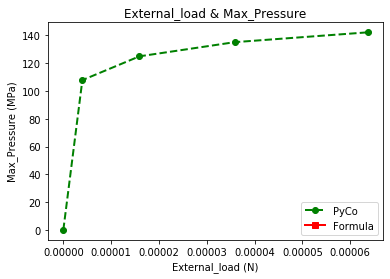

In [11]:
plt.plot(Exter_load,Max_Pressure,color="green",marker="o",linestyle="dashed",linewidth=2,label="PyCo")
plt.plot(F_External_load,F_Max_Pressure,color="red",marker="s",linewidth=2,label="Formula")
plt.xlabel("External_load (N)")
plt.ylabel("Max_Pressure (MPa)")
plt.title("External_load & Max_Pressure")
plt.legend()
plt.show()

# Plot of External_load & Contact_Area¶

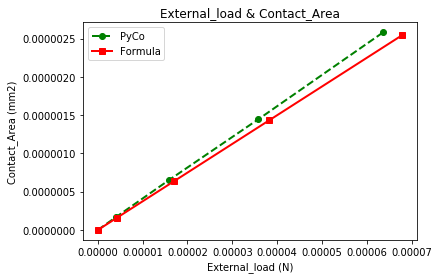

In [12]:
plt.plot(Exter_load,Contact_Area,color="green",marker="o",linestyle="dashed",linewidth=2,label="PyCo")
plt.plot(F_External_load,F_Contact_Area,color="red",marker="s",linewidth=2,label="Formula")
plt.xlabel("External_load (N)")
plt.ylabel("Contact_Area (mm2)")
plt.title("External_load & Contact_Area")
plt.legend()
plt.show()